# **Weekend Effect in Intensive Care Units**

## Investigating the Impact of Admission Timing on ICU Mortality Risk

Author: Kaveh Sarraf

In [2]:
# =============================================================================
# Import Dependencies
# =============================================================================
from pathlib import Path
import logging
import logging.handlers
import pandas as pd
import numpy as np
import os
import datetime as dt
import glob
import traceback
from scipy import stats
import datetime
from dateutil.relativedelta import relativedelta
import warnings
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from scipy.stats import linregress

import matplotlib.pyplot as plt

# =============================================================================
# Parameters
# =============================================================================

_PROCESS_NAME = 'Weekend_ICU_Mortality'
ERROR_COUNT = 0
ERROR_STR = ''

# =============================================================================
# Date Variables
# =============================================================================

now = dt.datetime.now()
today_str = now.strftime('%Y-%m-%d')

# =============================================================================
# Directories
# =============================================================================

# Set the path to the directory containing the MIMIC-III CSV files
data_path = r"D:\Documents\UNSW\HDAT 9910 - Capstone\UNSW MIMIC III\mimic_data\mimic_data\*.csv"

# Set the path to where output files will be stored
cwd = Path(r"D:\Python_Scripts\Projects\mimic_iii\Outputs")
cwd_str = str(cwd)

Set up logging

In [3]:
# =============================================================================
# Set up logging
# =============================================================================

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
log_file = os.path.join(cwd, F"{_PROCESS_NAME}_{today_str}.log")
handler = logging.handlers.RotatingFileHandler(log_file, maxBytes=1024 * 1024, backupCount=1)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# Set up logging to console
console_handler = logging.StreamHandler()
console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(console_formatter)
logger.addHandler(console_handler)

logger.info(F"=== Starting {_PROCESS_NAME}.py ===")

2023-04-22 23:19:54,929 - INFO - === Starting Research_Question_2.py ===


Read MIMIC III Datasets

In [3]:
# =============================================================================
# Read mimic iii datasets
# =============================================================================


# Read the relevant datasets into Pandas dataframes
def load_datasets(data_path):
    '''
    Load multiple CSV files into separate pandas dataframes and return them as variables with updated names.

    Parameters
    ----------
    data_path : str
        The path to the directory containing the CSV files.

    Returns
    -------
    dict
        A dictionary mapping the updated names of the dataframes (without the ".csv" extension) to the dataframes.

    Raises
    ------
    Exception
        If an error occurs while reading the CSV files.

    Notes
    -----
    - This function reads all CSV files in the `data_path` directory and its subdirectories.
    - Each CSV file is read in chunks of 20,000 rows.
    - The resulting dataframes are concatenated and returned as variables with updated names.

    '''
    
    global ERROR_COUNT
    global ERROR_STR
    
    try:
        # Obtain the list of csv files to read
        files = glob.glob(data_path, recursive=True)
        
        # Create an empty list to hold the file names
        file_names = []
        
        # Create an empty list to hold the dataframe names
        df_names = []
        
        # Create an empty list to hold the chunks of data
        chunks = []
        
        # Create an empty list to keep each dataframe
        df_list = []
        
        # Create an empty dictionary to hold the dataframes
        df_dict = {}
        
        start = dt.datetime.now()
        
        for file in files:
            # Counter variable to keep track of chunk number
            counter = 1
            # Split the file path using the backslash as the separator
            parts = file.split('\\')
            # Extract the last part
            file_name = parts[-1]
            file_names.append(file_name)
            
            logger.info(F"Reading: {file_name}")
            # Read the file in chunks and concatenate the resulting dataframes
            df_list = []
            for chunk in pd.read_csv(file, 
                                     chunksize=20000):
            
                # Increment the counter variable
                counter += 1
                # Append each chunk to the list of dataframes
                df_list.append(chunk)
                
            df = pd.concat(df_list, ignore_index=True)
            # Remove the ".csv" extension from the file name and use it as the key in the dictionary
            df_name = file_name.replace('.csv', '')
            df_dict[df_name] = df
            
        finish = dt.datetime.now()
        elapsed_time = finish - start
        hours, remainder = divmod(elapsed_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        
        logger.info("Finished reading ALL datasets")
        logger.info("Elapsed time: {} hours, {} minutes, {} seconds".format(hours, minutes, seconds))
        
        # Assign the dataframes to variables with the updated names
        for key, value in df_dict.items():
            locals()[key] = value
        
    except Exception as e:
        logger.info("Error occurred while reading datasets: {e}")
        logger.error(traceback.format_exc())
        ERROR_COUNT += 1
        ERROR_STR += F'{e}'
        
    return df_dict

# =============================================================================
# Load All datasets
# =============================================================================
# Call the load_datasets function to load the csv files into a dictionary
df_dict = load_datasets(data_path)

2023-04-22 11:07:04,436 - INFO - Reading: pt_icu_outcome.csv
2023-04-22 11:07:05,101 - INFO - Reading: vasopressors.csv
2023-04-22 11:07:06,125 - INFO - Reading: output_hourly.csv
2023-04-22 11:07:09,739 - INFO - Reading: antibiotics.csv
2023-04-22 11:07:10,812 - INFO - Reading: admissions.csv
2023-04-22 11:07:11,446 - INFO - Reading: pt_weight.csv
2023-04-22 11:07:13,198 - INFO - Reading: gcs_hourly.csv
2023-04-22 11:07:15,548 - INFO - Reading: transfers.csv
2023-04-22 11:07:16,962 - INFO - Reading: bloodculture.csv
2023-04-22 11:07:19,295 - INFO - Reading: patients.csv
2023-04-22 11:07:19,504 - INFO - Reading: icd9_diag.csv
2023-04-22 11:07:21,527 - INFO - Reading: labs_hourly.csv
2023-04-22 11:07:24,887 - INFO - Reading: icustays.csv
2023-04-22 11:07:25,499 - INFO - Reading: pt_stay_hr.csv
2023-04-22 11:07:49,280 - INFO - Reading: vitals_hourly.csv
2023-04-22 11:08:20,457 - INFO - Reading: pv_mechvent.csv
2023-04-22 11:08:26,921 - INFO - Finished reading ALL datasets
2023-04-22 11:0

### Data Pre-processing

----

1. Data Type QC

In [4]:
# =============================================================================
# ADMISSIONS
# =============================================================================

# Convert the admittime, dischtime, and deathtime columns to datetime data type in the admissions dataframe
df_dict['admissions']['admittime'] = pd.to_datetime(df_dict['admissions']['admittime'])
df_dict['admissions']['dischtime'] = pd.to_datetime(df_dict['admissions']['dischtime'])
df_dict['admissions']['deathtime'] = pd.to_datetime(df_dict['admissions']['deathtime'])
df_dict['admissions']['edregtime'] = pd.to_datetime(df_dict['admissions']['edregtime'])
df_dict['admissions']['edouttime'] = pd.to_datetime(df_dict['admissions']['edouttime'])

# =============================================================================
# ANTIBIOTICS
# =============================================================================

df_dict['antibiotics']['starttime'] = pd.to_datetime(df_dict['antibiotics']['starttime'])
df_dict['antibiotics']['endtime'] = pd.to_datetime(df_dict['antibiotics']['endtime'])

# =============================================================================
# BLOODCULTURE
# =============================================================================

df_dict['bloodculture']['charttime'] = pd.to_datetime(df_dict['bloodculture']['charttime'])
df_dict['bloodculture']['chartdate'] = pd.to_datetime(df_dict['bloodculture']['chartdate'])
df_dict['bloodculture']['positiveculture'] = df_dict['bloodculture']['positiveculture'].astype(bool)

# =============================================================================
# GCS_HOURLY
# =============================================================================

df_dict['gcs_hourly']['endotrachflag'] = df_dict['gcs_hourly']['endotrachflag'].astype(bool)

# =============================================================================
# ICUSTAYS
# =============================================================================

df_dict['icustays']['intime'] = pd.to_datetime(df_dict['icustays']['intime'])
df_dict['icustays']['outtime'] = pd.to_datetime(df_dict['icustays']['outtime'])

# =============================================================================
# PATIENTS
# =============================================================================

df_dict['patients']['dob'] = pd.to_datetime(df_dict['patients']['dob'])
df_dict['patients']['dod'] = pd.to_datetime(df_dict['patients']['dod'])
df_dict['patients']['dod_hosp'] = pd.to_datetime(df_dict['patients']['dod_hosp'])
df_dict['patients']['dod_ssn'] = pd.to_datetime(df_dict['patients']['dod_ssn'])
df_dict['patients']['expire_flag'] = df_dict['patients']['expire_flag'].astype(bool)

# =============================================================================
# PT_ICU_OUTCOME
# =============================================================================

df_dict['pt_icu_outcome']['dob'] = pd.to_datetime(df_dict['pt_icu_outcome']['dob'])
df_dict['pt_icu_outcome']['dod'] = pd.to_datetime(df_dict['pt_icu_outcome']['dod'])
df_dict['pt_icu_outcome']['admittime'] = pd.to_datetime(df_dict['pt_icu_outcome']['admittime'])
df_dict['pt_icu_outcome']['dischtime'] = pd.to_datetime(df_dict['pt_icu_outcome']['dischtime'])
df_dict['pt_icu_outcome']['intime'] = pd.to_datetime(df_dict['pt_icu_outcome']['intime'])
df_dict['pt_icu_outcome']['outtime'] = pd.to_datetime(df_dict['pt_icu_outcome']['outtime'])
df_dict['pt_icu_outcome']['hosp_deathtime'] = pd.to_datetime(df_dict['pt_icu_outcome']['hosp_deathtime'])
df_dict['pt_icu_outcome']['expire_flag'] = df_dict['pt_icu_outcome']['expire_flag'].astype(bool)
df_dict['pt_icu_outcome']['icu_expire_flag'] = df_dict['pt_icu_outcome']['icu_expire_flag'].astype(bool)
df_dict['pt_icu_outcome']['hospital_expire_flag'] = df_dict['pt_icu_outcome']['hospital_expire_flag'].astype(bool)

# =============================================================================
# PT_STAY_HR    
# =============================================================================

df_dict['pt_stay_hr']['intime'] = pd.to_datetime(df_dict['pt_stay_hr']['intime'])
df_dict['pt_stay_hr']['outtime'] = pd.to_datetime(df_dict['pt_stay_hr']['outtime'])
df_dict['pt_stay_hr']['starttime'] = pd.to_datetime(df_dict['pt_stay_hr']['starttime'])
df_dict['pt_stay_hr']['endtime'] = pd.to_datetime(df_dict['pt_stay_hr']['endtime'])

# =============================================================================
# PT_WEIGHT
# =============================================================================

df_dict['pt_weight']['starttime'] = pd.to_datetime(df_dict['pt_weight']['starttime'])
df_dict['pt_weight']['endtime'] = pd.to_datetime(df_dict['pt_weight']['endtime'])

# =============================================================================
# PV_MECHVENT
# =============================================================================

df_dict['pv_mechvent']['charttime'] = pd.to_datetime(df_dict['pv_mechvent']['charttime'])
df_dict['pv_mechvent']['starttime'] = pd.to_datetime(df_dict['pv_mechvent']['starttime'])
df_dict['pv_mechvent']['endtime'] = pd.to_datetime(df_dict['pv_mechvent']['endtime'])

# =============================================================================
# TRANSFERS
# =============================================================================

df_dict['transfers']['intime'] = pd.to_datetime(df_dict['transfers']['intime'])
df_dict['transfers']['outtime'] = pd.to_datetime(df_dict['transfers']['outtime'])

# =============================================================================
# VASOPRESSORS
# =============================================================================

df_dict['vasopressors']['starttime'] = pd.to_datetime(df_dict['vasopressors']['starttime'])
df_dict['vasopressors']['endtime'] = pd.to_datetime(df_dict['vasopressors']['endtime'])

# =============================================================================
# Get individual pandas dataframes from df_dict
# =============================================================================

# Sort keys of df_dict in alphabetical order
sorted_dict = {k: df_dict[k] for k in sorted(df_dict.keys())}
print(sorted_dict.keys())

(admissions, antibiotics, bloodculture, gcs_hourly, icd9_diag, icustays,
 labs_hourly, output_hourly, patients, pt_icu_outcome, pt_stay_hr, pt_weight,
 pv_mechvent, transfers, vasopressors, vitals_hourly) = sorted_dict.values()

dict_keys(['admissions', 'antibiotics', 'bloodculture', 'gcs_hourly', 'icd9_diag', 'icustays', 'labs_hourly', 'output_hourly', 'patients', 'pt_icu_outcome', 'pt_stay_hr', 'pt_weight', 'pv_mechvent', 'transfers', 'vasopressors', 'vitals_hourly'])


2. Handle Missing Values

In [ ]:
logger.info("Handling Missing Values")

###################
### antibiotics ###
###################

# Drop 'rate' and 'rateuom' columns since all values are blank 
antibiotics = antibiotics.drop(columns=['rate', 'rateuom'])
logger.info("antibiotics - Completed")

#################
### transfers ###
#################

'''
For outtime and los:
The missing values in these columns may indicate that the patients are still in the ICU or there is an error in the data collection. 
Lets remove the rows with missing values since there are only 6 records with missing values
'''
transfers.dropna(subset=['outtime', 'los'], inplace=True)

transfers.drop_duplicates(subset=['subject_id', 'hadm_id', 'icustay_id', 'dbsource',
                                  'eventtype', 'intime', 'outtime', 'los'], inplace=True)
logger.info("transfers - Completed")

####################
### bloodculture ###
####################
'''
For icustay_id and dy:
Remove the rows with missing values, as imputing them might not make sense:
'''
bloodculture.dropna(subset=['icustay_id', 'dy'], inplace=True)

'''
For org_name:
Since the missing values in this column corresponds with positiveculture=False, 
it would indicate indicate that no organism was identified in the blood culture. 
Lets replace the missing values with a placeholder value and create a new category for these cases:
'''
bloodculture['org_name'].fillna('No_Organism', inplace=True)

'''
For ab_name and antibioticresistance:
The missing values in these columns likely indicate that no resistance was detected. 
Lets replace the missing values with a placeholder value and create a new category for these cases:
'''
bloodculture['ab_name'].fillna('No_Antibiotic', inplace=True)
bloodculture['antibioticresistance'].fillna('No_Resistance', inplace=True)
logger.info("bloodculture - Completed")

##################
### pt_stay_hr ###
##################
# Create a boolean mask for rows with missing values
missing_values_mask = pt_stay_hr.isnull().any(axis=1)

# Select the rows with missing values using the mask
rows_with_missing_values = pt_stay_hr[missing_values_mask]

# replace missing values in 'dy' column by dividing corresponding 'hr' values with 24
pt_stay_hr['dy'] = pt_stay_hr['dy'].fillna(pt_stay_hr['hr'] / 24)

# replace missing values in 'starttime' and 'outtime' columns
pt_stay_hr['starttime'] = pt_stay_hr['starttime'].fillna(pt_stay_hr['intime']).combine_first(pt_stay_hr['intime'])
pt_stay_hr['endtime'] = pt_stay_hr['outtime'].fillna(pt_stay_hr['endtime']).combine_first(pt_stay_hr['endtime'])

# calculate missing values for 'hr' column
pt_stay_hr['hr'] = pd.to_datetime(pt_stay_hr['starttime']) - pd.to_datetime(pt_stay_hr['intime'])

# replace missing values in 'dy' column by dividing corresponding 'hr' values with 24
pt_stay_hr['dy'] = pt_stay_hr['dy'].fillna(pt_stay_hr['hr'] / 24)

logger.info("pt_stay_hr - Completed")

#####################
### vitals_hourly ###
#####################
vitals_hourly.sort_values(by=['icustay_id','hr'], inplace=True)

# Drop the fio2 column since most of the values are missing (6,341,965)
vitals_hourly = vitals_hourly.drop(['fio2'], axis=1)
logger.info("vitals_hourly - Completed")


## Feature Engineering

In [5]:
###################
### antibiotics ###
###################

# Total antibiotics administered: Calculate the total number of unique antibiotics administered to each patient in the ICU.
total_antibiotics = antibiotics.groupby('icustay_id')['label'].nunique().reset_index()
total_antibiotics.rename(columns={'label': 'total_unique_antibiotics'}, inplace=True)
logger.info("Feature Engineering completed for: antibiotics")

##################
### admissions ###
##################

admissions_copy = admissions.copy()

# Create a new binary feature 'weekend_admission' that indicates whether a patient was admitted to the ICU on a weekend (Saturday or Sunday)
admissions_copy['weekend_admission'] = admissions_copy['admittime'].apply(lambda x: x.weekday() >= 5).astype(int)

# Create 'hospital_mortality' feature using hospital_expire_flag column
admissions_copy['hospital_mortality'] = admissions_copy['hospital_expire_flag']

# Extract relevant features from datetime columns
admissions_copy['admit_day_of_week'] = admissions_copy['admittime'].dt.dayofweek
admissions_copy['admit_month'] = admissions_copy['admittime'].dt.month
admissions_copy['admit_year'] = admissions_copy['admittime'].dt.year

# Create a new boolean column called 'after_hours_admission' in the 'admissions_copy' DataFrame
# The 'apply' function is used to apply a custom lambda function to each row in the 'admittime' column
# The lambda function checks if the time of 'admittime' is between 18:01 and 6:00
# If the time is within this range, the value in the 'after_hours_admission' column is set to True, otherwise it is set to False
admissions_copy['after_hours_admission'] = admissions_copy['admittime'].apply(
    lambda x: True if (x.time() >= datetime.time(18, 1) or x.time() <= datetime.time(6, 0)) else False
)

# Drop the original datetime columns
admissions_copy.drop(['row_id', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime', 'hospital_expire_flag', 'diagnosis'], axis=1, inplace=True)

# Convert categorical variables to numeric representations (one-hot encoding)
admissions_copy = pd.get_dummies(admissions_copy, columns=['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity'])

def clean_feature_names(column_names):
    cleaned_columns = []
    for name in column_names:
        name = name.replace('<', 'less_than_')
        name = name.replace('>', 'greater_than_')
        name = name.replace('*', '_')
        name = re.sub(r'[/\-(),]', '_', name)
        name = re.sub(r'\[|\]', '', name)
        name = re.sub(r'\s', '_', name)  # Replace whitespaces with underscores
        cleaned_columns.append(name)
    return cleaned_columns

cleaned_columns = clean_feature_names(admissions_copy.columns)
admissions_copy.columns = cleaned_columns

def remove_double_underscores(column_name):
    return re.sub(r'_{2,}', '_', column_name)

# Apply the function to column names
new_column_names = [remove_double_underscores(col) for col in admissions_copy.columns]
# Update the dataframe column names
admissions_copy.columns = new_column_names
logger.info("Feature Engineering completed for: admissions")

#################
### pt_weight ###
#################

# Use the most reliable weight measurement. This is the the most relevant weight measurement for each patient 
pt_weight_mean = pt_weight.groupby('icustay_id')['avg_weight_naive'].mean().reset_index()
logger.info("Feature Engineering completed for: pt_weight")

#####################
### output_hourly ###
#####################

# Mean hourly urine output: Calculate the mean hourly urine output for each patient during their stay in the ICU.
mean_hourly_urine_output = output_hourly.groupby('icustay_id')['urineoutput'].mean().reset_index()
mean_hourly_urine_output.rename(columns={'urineoutput': 'mean_hourly_urineoutput'}, inplace=True)

# Minimum and maximum hourly urine output: Calculate the minimum and maximum hourly urine output for each patient during their stay in the ICU.
min_max_hourly_urine_output = output_hourly.groupby('icustay_id')['urineoutput'].agg(['min', 'max']).reset_index()
min_max_hourly_urine_output.rename(columns={'min': 'min_hourly_urineoutput', 'max': 'max_hourly_urineoutput'}, inplace=True)

# Merge the aggregated features: Merge the total, mean, minimum, and maximum urine output features into a single dataframe.
output_agg = mean_hourly_urine_output.merge(min_max_hourly_urine_output, on='icustay_id')
logger.info("Feature Engineering completed for: output_hourly")

####################
### vasopressors ###
####################

# Presence of vasopressors
def presence_flag(x):
    return 1 if any(x > 0) else 0

vasopressors_presence = vasopressors.groupby('icustay_id')[['norepinephrine_rate', 'epinephrine_rate', 'dopamine_rate', 'dobutamine_rate']].agg(presence_flag).reset_index()

# Define the new column names
new_column_names = {
    'norepinephrine_rate': 'norepinephrine_used',
    'epinephrine_rate': 'epinephrine_used',
    'dopamine_rate': 'dopamine_used',
    'dobutamine_rate': 'dobutamine_used'
    }

# Rename the columns
vasopressors_presence = vasopressors_presence.rename(columns=new_column_names)


# Number of vasopressor types used
vasopressors['num_vasopressor_types'] = vasopressors[['norepinephrine_rate', 'epinephrine_rate', 'dopamine_rate', 'dobutamine_rate']].apply(lambda x: (x != 0).astype(int).sum(), axis=1)
vasopressors_count = vasopressors.groupby('icustay_id')['num_vasopressor_types'].max().reset_index()

# Merge the aggregated features: This will make it easier to combine with other datasets and use as input for a machine learning model. 
vasopressors_agg = vasopressors_presence.merge(vasopressors_count, on='icustay_id')

# Define the custom function to check if any specified column value is 1 in the row and change the value to an integer
def any_vasopressor_used(row):
    columns_to_check = ['norepinephrine_used', 'epinephrine_used', 'dopamine_used', 'dobutamine_used']
    return int(any(row[column] == 1 for column in columns_to_check))

# Apply the custom function to each row in the vasopressors_presence DataFrame
vasopressors_agg['any_vasopressor_used'] = vasopressors_agg.apply(any_vasopressor_used, axis=1)
logger.info("Feature Engineering completed for: vasopressors")

##################
### gcs_hourly ###
##################

# Average GCS score: Calculate the average GCS score for each patient.
avg_gcs = gcs_hourly.groupby('icustay_id')['gcs'].mean().reset_index()
avg_gcs.rename(columns={'gcs': 'avg_gcs'}, inplace=True)

# Minimum and maximum GCS scores: Calculate the minimum and maximum GCS scores for each patient.
min_gcs = gcs_hourly.groupby('icustay_id')['gcs'].min().reset_index()
min_gcs.rename(columns={'gcs': 'min_gcs'}, inplace=True)

max_gcs = gcs_hourly.groupby('icustay_id')['gcs'].max().reset_index()
max_gcs.rename(columns={'gcs': 'max_gcs'}, inplace=True)

# Add a boolean feature called endotracheal_intubation that indicates whether each icustay_id received endotracheal intubation
endotracheal_intubation = gcs_hourly.groupby('icustay_id')['endotrachflag'].max().reset_index()
endotracheal_intubation.rename(columns={'endotrachflag': 'endotracheal_intubation'}, inplace=True)

# Endotracheal intubation: Calculate the proportion of endotracheal intubations (endotrachflag == 1) for each patient.
endotrach_proportion = gcs_hourly.groupby('icustay_id')['endotrachflag'].mean().reset_index()
endotrach_proportion.rename(columns={'endotrachflag': 'endotrach_proportion'}, inplace=True)

# Merge the aggregated features:
gcs_agg = avg_gcs.merge(min_gcs, on='icustay_id').merge(max_gcs, on='icustay_id').merge(endotrach_proportion, on='icustay_id').merge(endotracheal_intubation, on='icustay_id')
gcs_agg['avg_gcs'] = gcs_agg['avg_gcs'].round(0)
gcs_agg['endotrach_proportion'] = gcs_agg['endotrach_proportion'].round(2)
gcs_agg['gcs_measured'] = True
logger.info("Feature Engineering completed for: gcs_hourly")

#################
### transfers ###
#################

# Identify patients transferred
transfers['patient_transferred'] = transfers['eventtype'].apply(lambda x: False if x in ['admit', 'discharge'] else True)

# 1. Number of transfers: Calculate the total number of transfers for each icustay_id.
num_transfers = transfers.groupby('icustay_id').agg({'patient_transferred': 'sum'}).reset_index()
num_transfers.rename(columns={'patient_transferred': 'num_transfers'}, inplace=True)


# 2. Total transfer time: Calculate the total time spent during transfers for each icustay_id.

# Helper function to calculate transfer_time for each icustay_id
def calculate_transfer_time(group):
    admit_present = 'admit' in group['eventtype'].values
    transfer_present = 'transfer' in group['eventtype'].values
    transfer_count = group[group['eventtype'] == 'transfer'].shape[0]

    group['transfer_time'] = 0

    if admit_present and transfer_present:
        for i in range(1, len(group)):
            group.loc[group.index[i], 'transfer_time'] = group.loc[group.index[i], 'intime'] - group.loc[group.index[i - 1], 'outtime']
    elif transfer_present and transfer_count > 1:
        for i in range(1, len(group)):
            group.loc[group.index[i], 'transfer_time'] = group.loc[group.index[i], 'intime'] - group.loc[group.index[i - 1], 'outtime']

    return group

# Sort the dataframe
transfers_sorted = transfers.sort_values(['icustay_id', 'eventtype', 'intime', 'outtime'])

# Group the sorted dataframe by icustay_id and apply the helper function
transfers_sorted = transfers_sorted.groupby('icustay_id', group_keys=False).apply(calculate_transfer_time)
# Convert the 'transfer_time' column to timedelta type
transfers_sorted['transfer_time'] = pd.to_timedelta(transfers_sorted['transfer_time'])
# Convert transfer_time to seconds
transfers_sorted['transfer_time'] = transfers_sorted['transfer_time'].dt.total_seconds()

# Calculate the total time spent during transfers for each icustay_id
total_transfer_time = transfers_sorted.groupby('icustay_id')['transfer_time'].sum().reset_index()
total_transfer_time['transfer_time'] = total_transfer_time['transfer_time'].round(0)

# 3. Average transfer time: Calculate the average time spent during transfers for each icustay_id.
avg_transfer_time = transfers_sorted.groupby('icustay_id')['transfer_time'].mean().reset_index()
avg_transfer_time.rename(columns={'transfer_time': 'avg_transfer_time'}, inplace=True)
avg_transfer_time['avg_transfer_time'] = avg_transfer_time['avg_transfer_time'].round(0)

# Merge the features into a single dataframe
transfers_agg = num_transfers.merge(total_transfer_time, on='icustay_id').merge(avg_transfer_time, on='icustay_id')
logger.info("Feature Engineering completed for: transfers")

####################
### bloodculture ###
####################

# 1. Calculate the number of positive cultures for each icustay_id
# Filter only positive cultures
positive_cultures_df = bloodculture[bloodculture['positiveculture'] == 1]
# Calculate the number of unique positive cultures for each icustay_id
unique_positive_cultures = positive_cultures_df.groupby('icustay_id')['org_name'].nunique().reset_index()
unique_positive_cultures.columns = ['icustay_id', 'num_unique_positive_cultures']


# 2. Calculate the number of antibiotic resistance instances for each icustay_id
# Create a boolean 'resistance_flag' column
bloodculture['resistance_flag'] = bloodculture['antibioticresistance'] == 'R'
antibiotic_resistances = bloodculture[bloodculture['resistance_flag']].groupby('icustay_id')['ab_name'].nunique().reset_index()
antibiotic_resistances.rename(columns={'ab_name': 'num_unique_antibiotic_resistances'}, inplace=True)

# 3. Calculate the number of antibiotic susceptibility instances for each icustay_id
# Create a boolean flag called 'susceptible_flag'
bloodculture['susceptible_flag'] = bloodculture['antibioticresistance'].isin(['S', 'I'])

# Filter rows where 'susceptible_flag' is True
susceptible_cultures = bloodculture[bloodculture['susceptible_flag']]

# Group by icustay_id and calculate the number of unique ab_name where 'susceptible_flag' is True
unique_susceptible_cultures = susceptible_cultures.groupby('icustay_id')['ab_name'].nunique().reset_index()
unique_susceptible_cultures.columns = ['icustay_id', 'num_unique_susceptible_cultures']


# 4. Create a boolean flag for blood culture tests presence
bloodculture_presence = bloodculture[['icustay_id']].drop_duplicates()
bloodculture_presence['bloodculture_tested'] = True

# Merge the created features into a single DataFrame
bloodculture_features = bloodculture_presence.merge(antibiotic_resistances, on='icustay_id', how='left').merge(unique_positive_cultures, on='icustay_id', how='left').merge(unique_susceptible_cultures, on='icustay_id', how='left')

# Fill NaN values with 0 for 'num_positive_cultures' and 'num_antibiotic_resistances'
bloodculture_features[['num_unique_positive_cultures', 'num_unique_antibiotic_resistances', 'num_unique_susceptible_cultures']] = bloodculture_features[['num_unique_positive_cultures', 'num_unique_antibiotic_resistances', 'num_unique_susceptible_cultures']].fillna(0)
logger.info("Feature Engineering completed for: bloodculture")

###################
### labs_hourly ###
###################

# Obtain gender
# Merge labs_hourly icustays on icustay_id
labs_icustays_merged = labs_hourly.merge(icustays[['icustay_id', 'subject_id']], on='icustay_id')

# Merge labs_icustays_merged with patients on subject_id to get the gender
labs_icustays_patients_merged = labs_icustays_merged.merge(patients[['subject_id', 'gender']], on='subject_id')

'''
To feature engineer the labs_hourly_first_24h dataset:

1) Calculate the mean, minimum, and maximum values for each lab test (e.g., neutrophil, creatinine, etc.) per icustay_id.
2) Calculate the number of lab tests performed for each icustay_id.
3) Create binary features indicating the availability of each lab test result (e.g., neutrophil_available, creatinine_available, etc.) for each icustay_id.
'''

## Step 1: Calculate mean, min, and max values for each lab test per icustay_id
lab_test_columns = ['neutrophil', 'creactiveprotein', 'whitebloodcell',
                    'partialpressureo2', 'bicarbonate', 'lactate', 'troponin',
                    'bloodureanitrogen', 'creatinine', 'alaninetransaminase',
                    'aspartatetransaminase', 'hemoglobin', 'intnormalisedratio',
                    'platelets', 'albumin', 'chloride', 'glucose', 'sodium', 'bilirubin',
                    'hematocrit']

lab_stats = labs_icustays_patients_merged.groupby(['icustay_id', 'gender'])[lab_test_columns].agg(['mean', 'min', 'max']).reset_index()
lab_stats.columns = ['_'.join(col).strip() for col in lab_stats.columns.values]
lab_stats.rename(columns={'icustay_id_':'icustay_id', 'gender_':'gender'}, inplace=True)

# now create 4 categories:low, normal, high, not-tested for each test
'''
To create binary features indicating whether a patient's lab test result is within the normal range, above the normal range, or below the normal range or missing, you need to define the normal ranges for each lab test. Once you have the normal ranges, you can create the binary features by comparing the test results with the normal range limits.

Here's a general outline for creating the binary features:

Define the normal ranges for each lab test.
Create binary features by comparing the test results with the normal range limits.
Assuming you have a dictionary containing the normal ranges for each lab test as follows:
'''
normal_ranges = {
    'neutrophil': {'low': 45, 'high': 70, 'not_tested': np.nan},
    'creactiveprotein': {'low': 0, 'high': 0.8, 'not_tested': np.nan},
    'whitebloodcell': {'low': 4.5, 'high': 11, 'not_tested': np.nan},
    'partialpressureo2': {'low': 80, 'high': 100, 'not_tested': np.nan},
    'bicarbonate': {'low': 23, 'high': 28, 'not_tested': np.nan},
    'lactate': {'low': 0.7, 'high': 2.1, 'not_tested': np.nan},
    'troponin': {'low': 0, 'high': 0.05, 'not_tested': np.nan},
    'bloodureanitrogen': {'low': 45, 'high': 70, 'not_tested': np.nan},
    'alaninetransaminase': {'low': 10, 'high': 40, 'not_tested': np.nan},
    'aspartatetransaminase': {'low': 10, 'high': 40, 'not_tested': np.nan},
    'intnormalisedratio': {'low': 2, 'high': 3, 'not_tested': np.nan},
    'platelets': {'low': 150, 'high': 450, 'not_tested': np.nan},
    'albumin': {'low': 3.5, 'high': 5.5, 'not_tested': np.nan},
    'chloride': {'low': 98, 'high': 106, 'not_tested': np.nan},
    'glucose': {'low': 70, 'high': 99, 'not_tested': np.nan},
    'sodium': {'low': 136, 'high': 145, 'not_tested': np.nan},
    'bilirubin': {'low': 0.3, 'high': 1.0, 'not_tested': np.nan},
}

# You can then create the binary features:
# Loop through all the lab tests in normal_ranges
def get_range(value, low, high, not_tested):
    if pd.isnull(value):
        return 'not_tested'
    elif value < low:
        return 'low'
    elif value > high:
        return 'high'
    else:
        return 'normal'

for lab_test, ranges in normal_ranges.items():
    low = ranges['low']
    high = ranges['high']
    not_tested = ranges['not_tested']

    lab_stats[f'{lab_test}_range'] = lab_stats[f'{lab_test}_mean'].apply(
        lambda x: get_range(x, low, high, not_tested)
    )

gender_specific_normal_ranges = {
    'creatinine': {
        'M': {'low': 0.7, 'high': 1.3, 'not_tested': np.nan},
        'F': {'low': 0.5, 'high': 1.1, 'not_tested': np.nan},
    },
    'hemoglobin': {
        'M': {'low': 14, 'high': 18, 'not_tested': np.nan},
        'F': {'low': 12, 'high': 16, 'not_tested': np.nan},
    },
    'hematocrit': {
        'M': {'low': 42, 'high': 50, 'not_tested': np.nan},
        'F': {'low': 37, 'high': 47, 'not_tested': np.nan},
    },
}

def get_gender_specific_range(value, gender, low, high, not_tested):
    if pd.isnull(value):
        return 'not_tested'
    elif gender == 'M':
        if value < low['M']:
            return 'low'
        elif value > high['M']:
            return 'high'
        else:
            return 'normal'
    else:  # gender == 'F'
        if value < low['F']:
            return 'low'
        elif value > high['F']:
            return 'high'
        else:
            return 'normal'

for lab_test, ranges in gender_specific_normal_ranges.items():
    low = {'M': ranges['M']['low'], 'F': ranges['F']['low']}
    high = {'M': ranges['M']['high'], 'F': ranges['F']['high']}
    not_tested = {'M': ranges['M']['not_tested'], 'F': ranges['F']['not_tested']}

    lab_stats[f'{lab_test}_range'] = lab_stats.apply(
        lambda row: get_gender_specific_range(row[f'{lab_test}_mean'], row['gender'], low, high, not_tested), axis=1
    )

## Step 2: Calculate the maximum lab_test_number for each icustay_id
lab_test_range_columns = [f'{lab_test}_range' for lab_test in lab_test_columns]
lab_stats['lab_test_count'] = lab_stats[lab_test_range_columns].apply(lambda row: sum([1 for x in row if x != 'not_tested']), axis=1)

columns_to_keep = ['icustay_id', 'gender', 'lab_test_count', 'creatinine_range',
       'hemoglobin_range', 'hematocrit_range', 'neutrophil_range',
       'creactiveprotein_range', 'whitebloodcell_range',
       'partialpressureo2_range', 'bicarbonate_range', 'lactate_range',
       'troponin_range', 'bloodureanitrogen_range',
       'alaninetransaminase_range', 'aspartatetransaminase_range',
       'intnormalisedratio_range', 'platelets_range', 'albumin_range',
       'chloride_range', 'glucose_range', 'sodium_range', 'bilirubin_range']

lab_stats_trimmed = lab_stats[columns_to_keep]
logger.info("Feature Engineering completed for: labs_hourly")

################
### patients ###
################

# Merge the dataframes on 'subject_id'
patient_icu = pd.merge(patients, icustays, on='subject_id')

# Convert 'intime' and 'dob' to pandas Timestamp
patient_icu['intime'] = pd.to_datetime(patient_icu['intime'])
patient_icu['dob'] = pd.to_datetime(patient_icu['dob'])

# Calculate age in years and months
patient_icu['age'] = patient_icu.apply(lambda row: relativedelta(row['intime'], row['dob']).years + relativedelta(row['intime'], row['dob']).months / 12, axis=1)

# Set ages below 0 to 0
patient_icu.loc[patient_icu['age'] < 0, 'age'] = 0

patient_icu['age'] = patient_icu['age'].round(0)

columns_to_keep = ['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid',
       'intime', 'outtime', 'los', 'age']

patient_icu_trimmed = patient_icu[columns_to_keep]
logger.info("Feature Engineering completed for: patients")

#####################
### vitals_hourly ###
#####################

'''
Feature engineer the vitals_hourly table by extracting various summary statistics (mean, min, max, etc.) 
for each patient's (icustay_id) vital signs during their ICU stay.
'''

vitals_columns = ['spo2', 'temperature', 'resprate', 'heartrate','sysbp', 'diasbp', 'glucose', 'meanarterialpressure']

vitals_stats = vitals_hourly.groupby(['icustay_id'])[vitals_columns].agg(['mean', 'min', 'max']).reset_index()
vitals_stats.columns = ['_'.join(col).strip() for col in vitals_stats.columns.values]
vitals_stats.rename(columns={'icustay_id_':'icustay_id'}, inplace=True)

# Merge vitals_stats with patient_icu on icu_stay_id
vitals_stats = vitals_stats.merge(patient_icu[['icustay_id', 'age']], on='icustay_id', how='left')

spo2_ranges = {
    "age_<1": {"low": 95, "high": 100},
    "age_1-3": {"low": 95, "high": 100},
    "age_4-6": {"low": 95, "high": 100},
    "age_7-12": {"low": 95, "high": 100},
    "age_13-18": {"low": 95, "high": 100},
    "age_19-65": {"low": 95, "high": 100},
    "age_>65": {"low": 95, "high": 100},
}

temperature_ranges = {
    "age_<1": {"low": 36.7, "high": 37.3},
    "age_1-3": {"low": 36.4, "high": 37.4},
    "age_4-6": {"low": 36.4, "high": 37.4},
    "age_7-12": {"low": 36.4, "high": 37.4},
    "age_13-18": {"low": 36.4, "high": 37.4},
    "age_19-65": {"low": 35.6, "high": 36.7},
    "age_>65": {"low": 33.9, "high": 37.0},
}

resprate_ranges = {
    "age_<1": {"low": 30, "high": 60},
    "age_1-3": {"low": 24, "high": 40},
    "age_4-6": {"low": 22, "high": 34},
    "age_7-12": {"low": 18, "high": 30},
    "age_13-18": {"low": 12, "high": 16},
    "age_19-65": {"low": 12, "high": 20},
    "age_>65": {"low": 12, "high": 20},
}

heartrate_ranges = {
    "age_<1": {"low": 70, "high": 190},
    "age_1-3": {"low": 80, "high": 130},
    "age_4-6": {"low": 75, "high": 115},
    "age_7-12": {"low": 70, "high": 110},
    "age_13-18": {"low": 60, "high": 100},
    "age_19-65": {"low": 60, "high": 100},
    "age_>65": {"low": 60, "high": 100},
}

sysbp_ranges = {
    "age_<1": {"low": 65, "high": 100},
    "age_1-3": {"low": 90, "high": 105},
    "age_4-6": {"low": 95, "high": 110},
    "age_7-12": {"low": 100, "high": 120},
    "age_13-18": {"low": 100, "high": 120},
    "age_19-65": {"low": 100, "high": 120},
    "age_>65": {"low": 100, "high": 120},
}

diasbp_ranges = {
    "age_<1": {"low": 45, "high": 65},
    "age_1-3": {"low": 55, "high": 70},
    "age_4-6": {"low": 60, "high": 75},
    "age_7-12": {"low": 60, "high": 75},
    "age_13-18": {"low": 70, "high": 80},
    "age_19-65": {"low": 70, "high": 80},
    "age_>65": {"low": 70, "high": 80},
}

meanarterialpressure_ranges = {
    "age_<1": {"low": 28, "high": 62},
    "age_1-3": {"low": 49, "high": 62},
    "age_4-6": {"low": 58, "high": 69},
    "age_7-12": {"low": 66, "high": 79},
    "age_13-18": {"low": 70, "high": 100},
    "age_19-65": {"low": 70, "high": 110},
    "age_>65": {"low": 70, "high": 110},
}

glucose_ranges = {
    "age_<1": {"low": 30, "high": 90},
    "age_1-3": {"low": 60, "high": 100},
    "age_4-6": {"low": 60, "high": 100},
    "age_7-12": {"low": 60, "high": 100},
    "age_13-18": {"low": 60, "high": 100},
    "age_19-65": {"low": 74, "high": 106},
    "age_>65": {"low": 74, "high": 106},
}

# create an 'age_group' column in the vitals_stats DataFrame
def assign_age_group(age):
    if age < 1:
        return "age_<1"
    elif 1 <= age <= 3:
        return "age_1-3"
    elif 4 <= age <= 6:
        return "age_4-6"
    elif 7 <= age <= 12:
        return "age_7-12"
    elif 13 <= age <= 18:
        return "age_13-18"
    elif 19 <= age <= 65:
        return "age_19-65"
    else:
        return "age_>65"

vitals_stats['age_group'] = vitals_stats['age'].apply(assign_age_group)


def get_vital_status(vital_ranges, age_group, value):
    if pd.isna(value):
        return "not_measured"

    if age_group in vital_ranges:
        age_group_ranges = vital_ranges[age_group]
        if value < age_group_ranges["low"]:
            return "low"
        elif age_group_ranges["low"] <= value <= age_group_ranges["high"]:
            return "normal"
        else:
            return "high"

    return "unknown_age_group"

# mean
vitals_stats["spo2_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(spo2_ranges, row["age_group"], row["spo2_mean"]), axis=1)
vitals_stats["temperature_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(temperature_ranges, row["age_group"], row["temperature_mean"]), axis=1)
vitals_stats["resprate_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(resprate_ranges, row["age_group"], row["resprate_mean"]), axis=1)
vitals_stats["heartrate_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(heartrate_ranges, row["age_group"], row["heartrate_mean"]), axis=1)
vitals_stats["sysbp_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(sysbp_ranges, row["age_group"], row["sysbp_mean"]), axis=1)
vitals_stats["diasbp_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(diasbp_ranges, row["age_group"], row["diasbp_mean"]), axis=1)
vitals_stats["glucose_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(glucose_ranges, row["age_group"], row["glucose_mean"]), axis=1)
vitals_stats["meanarterialpressure_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(meanarterialpressure_ranges, row["age_group"], row["meanarterialpressure_mean"]), axis=1)


columns_to_keep = ['icustay_id', 'age', 'age_group', 'spo2_mean_status',
       'temperature_mean_status', 'resprate_mean_status',
       'heartrate_mean_status', 'sysbp_mean_status', 'diasbp_mean_status',
       'glucose_mean_status', 'meanarterialpressure_mean_status'
       ]

vitals_stats_trimmed = vitals_stats[columns_to_keep]
logger.info("Feature Engineering completed for: vitals_hourly")

#################
### icd9_diag ###
#################

icd9_diag_copied = icd9_diag.copy()
icd9_diag_copy = pd.merge(icd9_diag_copied, icustays[['icustay_id','subject_id','hadm_id']], on =['subject_id','hadm_id'], how='left')
icd9_diag_copy.sort_values(by='subject_id', inplace=True)

# Drop rows with missing 'icustay_id' since these patients did not attend an ICU
icd9_diag_copy = icd9_diag_copy.dropna(subset=['icustay_id'])


# 1. Code hierarchy: 
'''
ICD-9 codes are hierarchical, with the first three digits representing a category, and additional digits providing more specific information. 
Lets extract the first three digits as a separate feature, representing the general diagnostic category.
'''
icd9_diag_copy['icd9_code_category'] = icd9_diag_copy['icd9_code'].apply(lambda code: str(code)[:3])


# 2. Text-based features: 
'''
Lets uselong titles to create text-based features, such as:
    * Number of words in the title
    * Presence of specific keywords
    * Use of text embeddings, such as Word2Vec, GloVe, or BERT, to represent the titles as vectors
'''

# a) number of words in  long titles
'''
Step 1. Download the 'punkt' resource from the Natural Language Toolkit (nltk) library. 
The 'punkt' resource is a pre-trained tokenizer model that is used for sentence tokenization and word tokenization.

Tokenization is the process of breaking text into smaller units called tokens, which can be sentences or words. 
The 'punkt' tokenizer is specifically designed to split a text into sentences and words effectively, taking into 
account punctuation, abbreviations, and other factors that can make tokenization more challenging.

    * Sentence tokenization: It splits a text into individual sentences. For example, given the text "I love ice cream. It's my favorite dessert.", 
        'punkt' would tokenize it into two separate sentences: ["I love ice cream.", "It's my favorite dessert."]
    * Word tokenization: It breaks a sentence into words and punctuation. For example, given the sentence "I love ice cream.", 
        'punkt' would tokenize it into the following list: ["I", "love", "ice", "cream", "."]

By using the 'punkt' tokenizer, we can effectively break down text into smaller units that can be further analysed or 
processed in various natural language processing (NLP) tasks.
'''
nltk.download('punkt')

def count_words_without_punctuation(text):
    if pd.notnull(text):
        # Remove punctuation marks using a regular expression
        text_no_punct = re.sub(r'[^\w\s]', '', text)
        return len(word_tokenize(text_no_punct))
    else:
        return 0

icd9_diag_copy['long_title_num_words'] = icd9_diag_copy['long_title'].apply(count_words_without_punctuation)

# b) check for the presence of specific keywords 
'''
These keywords would be relevant to icu mortality rates as they are associated with severe conditions and 
complications that may impact patient outcomes
'''
keywords = ['aneurysm',
            'poisoning',
            'acute',
            'infection',
            'infectious',
            'infarction',
            'suicide',
            'fracture',
            'sepsis',
            'hemorrhage',
            'injury',
            'shock',
            'heart',
            'failure',
            'cardiac',
            'coronary',
            'cardiovascular',
            'embolism',
            'respiratory',
            'lung',
            'renal',
            'kidney',
            'liver',
            'hepatic',
            'vehicle',
            'neoplasm',
            'stroke',
            'hypotension']

for keyword in keywords:
    icd9_diag_copy[f'long_title_has_{keyword}'] = icd9_diag_copy['long_title'].apply(lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0)

# Note: We will only use long title to prevent risking co-linearity issues.

# c) Combine related diagnoses: group related diagnoses together to create higher-level categories, which could be useful in predicting outcomes or understanding trends in the data.

def map_icd9_category_to_description(icd9_code_category):
    if icd9_code_category.isdigit():
        code = int(icd9_code_category)
        if 1 <= code <= 139:
            return 'Infectious And Parasitic Diseases'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        elif 240 <= code <= 279:
            return 'Endocrine, Metabolic Diseases, And Immunity Disorders'
        elif 280 <= code <= 289:
            return 'Diseases Of The Blood'
        elif 290 <= code <= 319:
            return 'Mental Disorders'
        elif 320 <= code <= 389:
            return 'Nervous System Disorders'
        elif 390 <= code <= 459:
            return 'Circulatory System Disorders'
        elif 460 <= code <= 519:
            return 'Respiratory System Disorders'
        elif 520 <= code <= 579:
            return 'Digestive System Disorders'
        elif 580 <= code <= 629:
            return 'Genitourinary System Disorders'
        elif 630 <= code <= 679:
            return 'Pregnancy, Childbirth, And The Puerperium Complications'
        elif 680 <= code <= 709:
            return 'Skin And Subcutaneous Tissue Disorders'
        elif 710 <= code <= 739:
            return 'Musculoskeletal System And Connective Tissue Disorders'
        elif 740 <= code <= 759:
            return 'Congenital Anomalies'
        elif 760 <= code <= 779:
            return 'Conditions Originating In The Perinatal Period'
        elif 780 <= code <= 799:
            return 'Symptoms, Signs, And Ill-Defined Conditions'
        elif 800 <= code <= 999:
            return 'Injury And Poisoning'
    else:
        if icd9_code_category.startswith('V'):
            return 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
        elif icd9_code_category.startswith('E'):
            return 'Supplementary Classification Of External Causes Of Injury And Poisoning'

    return 'Unknown_icd9_category_description'

icd9_diag_copy['icd9_category_description'] = icd9_diag_copy['icd9_code_category'].apply(map_icd9_category_to_description)

# d) Frequency-based features: create features based on the frequency of specific ICD-9 codes, categories, or keywords in the dataset, 
# which might help identify common or rare diagnoses.
# Step 1: Calculate the frequency of ICD-9 codes and categories
icd9_code_freq = icd9_diag_copy['icd9_code'].value_counts(normalize=True)
icd9_category_freq = icd9_diag_copy['icd9_code_category'].value_counts(normalize=True)

# Step 2: Create new columns in the DataFrame to store these frequency-based features
icd9_diag_copy['icd9_code_frequency'] = icd9_diag_copy['icd9_code'].apply(lambda x: icd9_code_freq.get(x, 0))
icd9_diag_copy['icd9_category_frequency'] = icd9_diag_copy['icd9_code_category'].apply(lambda x: icd9_category_freq.get(x, 0))

# e) Use Word2Vec text embeddings to represent the titles as vectors
'''  
combined_title_word2vec is a way to represent the meaning of the words in the titles (short and long titles) using numbers. 
The output for combined_title_word2vec is a list of numbers, called a vector, which captures the essence of the title's meaning. 
This helps in understanding the content of the titles without actually reading them.
The purpose of using combined_title_word2vec is to help machines better understand the titles' meaning by capturing the relationship between words. 
By doing this, we can use these numerical representations in various machine learning tasks, such as grouping similar diagnoses together, predicting related conditions, or understanding the severity of a condition based on its title.

In summary, combined_title_word2vec is a numerical representation of the titles' meaning that helps machines understand and work with the content of the titles in a more effective way.
'''
# Lets use the long titles only with Word2Vec
long_title_tokenised = icd9_diag_copy['long_title'].apply(lambda x: word_tokenize(x.lower()) if pd.notnull(x) else [])

# Train Word2Vec model on the combined titles
model = Word2Vec(sentences=long_title_tokenised, vector_size=100, window=5, min_count=1, workers=4)

'''
When training a Word2Vec model, you don't need to split the data into training and test sets. 
The purpose of Word2Vec is to learn word embeddings, i.e., vector representations of words, based on their context in the text. 
The model learns these embeddings by training on the entire dataset, so it's not necessary to split it.
However, when you apply the learned word embeddings to a downstream machine learning task, 
such as classification or regression, you should split the dataset into training and test sets. 
This is because you want to evaluate the performance of your model on unseen data.
In summary, the Word2Vec model learns word embeddings using the entire dataset, and you only need to split 
the data into training and test sets when using those embeddings for a specific machine learning task.
'''
# Calculate the average Word2Vec vector for each title
def average_word2vec(title, model):
    if not pd.isnull(title):
        words = word_tokenize(title.lower())
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if len(word_vectors) > 0:
            return np.mean(word_vectors, axis=0)
    return np.zeros(model.vector_size)

icd9_diag_copy['long_title_word2vec'] = icd9_diag_copy['long_title'].apply(lambda x: average_word2vec(x, model))

### Aggregate data ###
# Group the DataFrame by subject_id
grouped_icd9 = icd9_diag_copy.groupby('hadm_id')

# 1. Total number of ICD-9 codes per patient
num_icd9_codes = grouped_icd9['icd9_code'].count()
num_icd9_codes = num_icd9_codes.rename('icd9_code_count')  # Rename the column


# 2. Count of ICD-9 codes per category for each patient
category_count = pd.pivot_table(icd9_diag_copy, index='hadm_id', columns='icd9_category_description', values='icd9_code', aggfunc='count', fill_value=0)

# 3. Count of ICD-9 codes with specific keywords for each patient
keyword_columns = [col for col in icd9_diag_copy.columns if col.startswith('long_title_has_')]
keyword_counts = icd9_diag_copy.groupby('hadm_id')[keyword_columns].sum()

# 4. Mean or median frequency of ICD-9 codes/categories for each patient
mean_code_freq = grouped_icd9['icd9_code_frequency'].mean()
median_category_freq = grouped_icd9['icd9_category_frequency'].median()

# 5. Sum, mean, or median of word count or presence of specific keywords in long_title
mean_long_title_word_count = grouped_icd9['long_title_num_words'].mean()

# 6. Summary statistics of the seq_num column, such as min, max, mean, and median
seq_num_summary = grouped_icd9['seq_num'].agg(['min', 'max', 'mean', 'median'])
seq_num_summary.rename(columns={'min':'min_seq_num', 
                                'max':'max_seq_num', 
                                'mean':'mean_seq_num', 
                                'median':'median_seq_num'}, inplace=True)

# 7. Presence of any rare or very common ICD-9 codes
rare_codes = icd9_diag_copy['icd9_code_frequency'] < icd9_diag_copy['icd9_code_frequency'].quantile(0.05)
common_codes = icd9_diag_copy['icd9_code_frequency'] > icd9_diag_copy['icd9_code_frequency'].quantile(0.95)
icd9_diag_copy['rare_code'] = rare_codes
icd9_diag_copy['common_code'] = common_codes
rare_common_summary = icd9_diag_copy.groupby('hadm_id')[['rare_code', 'common_code']].sum()

# 8. Calculate the average Word2Vec vector for each patient:
'''
average_word2vec function takes a group of ICD-9 diagnoses for a patient and calculates the mean of the Word2Vec vectors 
in the long_title_word2vec column. 
This will give you a single vector representing the overall semantic meaning of the ICD-9 diagnoses for each patient.
Once we have calculated the average Word2Vec vector for each patient, we can use it as a feature in your machine learning model. 
This feature may help capture the overall theme of a patient's diagnoses and potentially provide useful information for predicting 
outcomes or understanding trends in the data.
'''
def average_word2vec(group):
    word2vec_vectors = group['long_title_word2vec'].tolist()
    return np.mean(word2vec_vectors, axis=0)

avg_word2vec = grouped_icd9.apply(average_word2vec)
avg_word2vec = avg_word2vec.rename("avg_word2vec")
avg_word2vec_df = avg_word2vec.reset_index()
avg_word2vec_df.set_index('hadm_id', inplace=True)  # Set the 'hadm_id' column as the index

# Combine all aggregated features into a new DataFrame
icd9_diag_aggregated_features = pd.concat([
                                            num_icd9_codes,
                                            category_count,
                                            keyword_counts,
                                            mean_code_freq,
                                            median_category_freq,
                                            mean_long_title_word_count,
                                            seq_num_summary,
                                            rare_common_summary,
                                            avg_word2vec_df
                                            ], axis=1).reset_index()

logger.info("Feature Engineering completed for: icd9_diag")

###################
### pv_mechvent ###
###################

# Group the DataFrame by icustay_id
grouped_pv = pv_mechvent.groupby('icustay_id')

# Calculate the number of ventilation changes for each icustay_id
vent_changes = grouped_pv['ventnum'].nunique().reset_index().rename(columns={'ventnum': 'mechanical_vent_episode_count'})
vent_changes['mechanical_vent_needed'] = True

logger.info("Feature Engineering completed for: pv_mechvent")


2023-04-22 13:26:09,477 - INFO - Feature Engineering completed for: antibiotics
2023-04-22 13:26:16,545 - INFO - Feature Engineering completed for: admissions
2023-04-22 13:26:16,628 - INFO - Feature Engineering completed for: pt_weight
2023-04-22 13:26:17,398 - INFO - Feature Engineering completed for: output_hourly
2023-04-22 13:29:08,512 - INFO - Feature Engineering completed for: vasopressors
2023-04-22 13:29:09,292 - INFO - Feature Engineering completed for: gcs_hourly
2023-04-22 13:34:06,108 - INFO - Feature Engineering completed for: transfers
2023-04-22 13:34:07,276 - INFO - Feature Engineering completed for: bloodculture
2023-04-22 13:34:29,206 - INFO - Feature Engineering completed for: labs_hourly
2023-04-22 13:34:42,491 - INFO - Feature Engineering completed for: patients
2023-04-22 13:35:15,822 - INFO - Feature Engineering completed for: vitals_hourly
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package 

## Merge Datasets

In [6]:

icu_patient_admissions = pd.merge(patient_icu_trimmed, admissions_copy, how='left', on=['subject_id', 'hadm_id'])

merge1 = pd.merge(icu_patient_admissions, vasopressors_agg, how='left', on='icustay_id')

added_columns = ['norepinephrine_used', 'epinephrine_used','dopamine_used', 
                 'dobutamine_used', 'num_vasopressor_types','any_vasopressor_used']

# Fill missing values with 0 since those patients were not given any vasopressors
merge1[added_columns] = merge1[added_columns].fillna(0).astype(int)

merge2 = pd.merge(merge1, output_agg, how='left', on=['icustay_id'] )

merge3 = pd.merge(merge2, total_antibiotics, how='left', on=['icustay_id'])

# Fill missing values with 0 since patient was not prescribed an antibiotic
merge3['total_unique_antibiotics'] = merge3['total_unique_antibiotics'].fillna(0).astype(int)

merge4 = pd.merge(merge3, pt_weight_mean, how='left', on=['icustay_id'] )

merge5 = pd.merge(merge4, gcs_agg, how='left', on=['icustay_id'])

# Fill missing values with False since did not require gcs or intubation
merge5[['endotracheal_intubation', 'gcs_measured']] = merge5[['endotracheal_intubation', 'gcs_measured']].fillna(False).astype(bool)

merge6 = pd.merge(merge5, transfers_agg, how='left', on=['icustay_id'])

# Columns to replace missing values with 0
columns_to_replace = [ 'num_transfers', 'transfer_time', 'avg_transfer_time']

# Replace missing values with 0 for each column since the patients with missing data were not transferred
for col in columns_to_replace:
    merge6[col] = merge6[col].fillna(0)

merge7 = pd.merge(merge6, bloodculture_features, how='left', on=['icustay_id'])

# Patients with missing values did not have their blood culture tested:
merge7['bloodculture_tested'] = merge7['bloodculture_tested'].fillna(False).astype(bool)

# Columns to replace missing values with 0
columns_to_replace = ['num_unique_antibiotic_resistances', 
                      'num_unique_positive_cultures','num_unique_susceptible_cultures']

# Replace missing values with 0 for each column
for col in columns_to_replace:
    merge7[col] = merge7[col].fillna(0)

merge8 = pd.merge(merge7, lab_stats_trimmed, how='left', on=['icustay_id', 'gender'] )

merge8['lab_test_count'] = merge8['lab_test_count'].fillna(0)

columns_to_replace = [ 'creatinine_range',
       'hemoglobin_range', 'hematocrit_range', 'neutrophil_range',
       'creactiveprotein_range', 'whitebloodcell_range',
       'partialpressureo2_range', 'bicarbonate_range', 'lactate_range',
       'troponin_range', 'bloodureanitrogen_range',
       'alaninetransaminase_range', 'aspartatetransaminase_range',
       'intnormalisedratio_range', 'platelets_range', 'albumin_range',
       'chloride_range', 'glucose_range', 'sodium_range', 'bilirubin_range']

# Replace missing values with 'not_tested' for each column
for col in columns_to_replace:
    merge8[col] = merge8[col].fillna('not_tested')

merge9 = pd.merge(merge8, vitals_stats_trimmed, how='left', on=['icustay_id', 'age'])

# Replace missing values with 'not_measured' for each column
columns_to_replace = [ 'spo2_mean_status',
       'temperature_mean_status', 'resprate_mean_status',
       'heartrate_mean_status', 'sysbp_mean_status', 'diasbp_mean_status',
       'glucose_mean_status', 'meanarterialpressure_mean_status']

for col in columns_to_replace:
    merge9[col] = merge9[col].fillna('not_measured')

# Re-assign age_group to all patients to capture those missing from vitals_stats_trimmed dataframe
merge9['age_group'] = merge9['age'].apply(assign_age_group)

merge10 = pd.merge(merge9, icd9_diag_aggregated_features, how='left', on=['hadm_id'])

# Columns to replace missing values with median
columns_to_replace = [ 'icd9_code_count', 'Circulatory System Disorders',
       'Conditions Originating In The Perinatal Period',
       'Congenital Anomalies', 'Digestive System Disorders',
       'Diseases Of The Blood',
       'Endocrine, Metabolic Diseases, And Immunity Disorders',
       'Genitourinary System Disorders', 'Infectious And Parasitic Diseases',
       'Injury And Poisoning', 'Mental Disorders',
       'Musculoskeletal System And Connective Tissue Disorders', 'Neoplasms',
       'Nervous System Disorders',
       'Pregnancy, Childbirth, And The Puerperium Complications',
       'Respiratory System Disorders',
       'Skin And Subcutaneous Tissue Disorders',
       'Supplementary Classification Of External Causes Of Injury And Poisoning',
       'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services',
       'Symptoms, Signs, And Ill-Defined Conditions', 
       'Unknown_icd9_category_description',
       'long_title_has_aneurysm', 'long_title_has_poisoning',
       'long_title_has_acute', 'long_title_has_infection',
       'long_title_has_infectious', 'long_title_has_infarction',
       'long_title_has_suicide', 'long_title_has_fracture',
       'long_title_has_sepsis', 'long_title_has_hemorrhage',
       'long_title_has_injury', 'long_title_has_shock', 'long_title_has_heart',
       'long_title_has_failure', 'long_title_has_cardiac',
       'long_title_has_coronary', 'long_title_has_cardiovascular',
       'long_title_has_embolism', 'long_title_has_respiratory',
       'long_title_has_lung', 'long_title_has_renal', 'long_title_has_kidney',
       'long_title_has_liver', 'long_title_has_hepatic',
       'long_title_has_vehicle', 
       'long_title_has_neoplasm', 'long_title_has_stroke',
       'long_title_has_hypotension', 'icd9_code_frequency',
       'icd9_category_frequency', 
       'long_title_num_words', 'min_seq_num', 'max_seq_num', 'mean_seq_num',
       'median_seq_num', 'rare_code', 'common_code']
# Replace missing values with 0 for each column
for col in columns_to_replace:
    merge10[col] = merge10[col].fillna(0)

feature_engineered_df = pd.merge(merge10, vent_changes, how='left', on=['icustay_id'])

# Patients with missing 'mechanical_vent_needed' indicate no mechanical ventilation was needed
feature_engineered_df['mechanical_vent_needed'] = feature_engineered_df['mechanical_vent_needed'].fillna(False).astype(bool)
feature_engineered_df['mechanical_vent_episode_count'] = feature_engineered_df['mechanical_vent_episode_count'].fillna(0)

# Drop columns with missing values that have no relation to research question 1
'''
The 'hospital_expire_flag' is highly correlated with the target variable 'expire_flag', which might cause multicollinearity issues 
in the logistic regression model. Lets drop 'expire_flag'
'''
columns_to_drop = ['dod','dod_hosp', 'dod_ssn', 'expire_flag', 'outtime', 'los', 'first_wardid', 
                   'last_wardid', 'dob', 'intime']
feature_engineered_df.drop(columns_to_drop, axis=1, inplace=True)

# One-hot encoding for each column in the list
columns_to_encode = ['first_careunit', 'last_careunit','age_group',
                     'hemoglobin_range', 'hematocrit_range', 'neutrophil_range',
                    'creactiveprotein_range', 'whitebloodcell_range',
                    'partialpressureo2_range', 'bicarbonate_range', 'lactate_range',
                    'troponin_range', 'bloodureanitrogen_range', 'creatinine_range',
                    'alaninetransaminase_range', 'aspartatetransaminase_range',
                    'intnormalisedratio_range', 'platelets_range', 'albumin_range',
                    'chloride_range', 'glucose_range', 'sodium_range', 'bilirubin_range',
                    'spo2_mean_status','temperature_mean_status', 'resprate_mean_status',
                    'heartrate_mean_status', 'sysbp_mean_status', 'diasbp_mean_status',
                    'glucose_mean_status', 'meanarterialpressure_mean_status'
                     ]

for column in columns_to_encode:
    one_hot_encoded = pd.get_dummies(feature_engineered_df[column], prefix=column)
    feature_engineered_df = pd.concat([feature_engineered_df, one_hot_encoded], axis=1)
    feature_engineered_df.drop(column, axis=1, inplace=True)

# use the map() function to convert the 'gender' column in feature_engineered_df to 0 for Male and 1 for Female
feature_engineered_df['gender'] = feature_engineered_df['gender'].map({'M': 0, 'F': 1})

'''
It seems that the 'avg_word2vec' column contains a string representation of a list of numbers (floats). 
In order to use the StandardScaler, we need to split this string into individual float values and create new columns for each value. 
'''
# Create new DataFrames for the values in the NumPy array
new_columns = {}

for i in range(len(feature_engineered_df['avg_word2vec'].iloc[0])):
    column_name = f"avg_word2vec_{i}"
    new_columns[column_name] = feature_engineered_df['avg_word2vec'].apply(lambda x: x[i])

new_columns_df = pd.DataFrame(new_columns)

# Concatenate the new DataFrames with the original one
feature_engineered_df = pd.concat([feature_engineered_df.drop(columns=['avg_word2vec']), new_columns_df], axis=1)


# Replace the * , / , [ , ] , < and > signs in column names to prevent errors when running xgboost
def clean_feature_names(column_names):
    cleaned_columns = []  # Create an empty list to store cleaned column names

    # Iterate through each column name in the input list
    for name in column_names:
        # Replace '<' with 'less_than_'
        name = name.replace('<', 'less_than_')
        # Replace '>' with 'greater_than_'
        name = name.replace('>', 'greater_than_')
        # Replace '*' with '_'
        name = name.replace('*', '_')
        # Replace '/', '-', '(', and ')' with '_'
        name = re.sub(r'[/\-(),]', '_', name)
        # Remove '[' and ']'
        name = re.sub(r'\[|\]', '', name)
        # Replace whitespaces with underscores
        name = re.sub(r'\s', '_', name)

        # Append the cleaned name to the cleaned_columns list
        cleaned_columns.append(name)

    # Return the list of cleaned column names
    return cleaned_columns

cleaned_columns = clean_feature_names(feature_engineered_df.columns)
feature_engineered_df.columns = cleaned_columns

# Next, remove double underscores __
def remove_double_underscores(column_name):
    return re.sub(r'_{2,}', '_', column_name)

# Apply the function to column names
new_column_names = [remove_double_underscores(col) for col in feature_engineered_df.columns]

# Update the dataframe column names
feature_engineered_df.columns = new_column_names

Export `feature_engineered_df` dataframe as `pickle` and `csv` file types for future use.

In [7]:
# Export the final dataframe
feature_engineered_df.to_pickle(cwd/'feature_engineered_df_question2.pkl')
feature_engineered_df.to_csv(cwd/'feature_engineered_df_question2.csv', index=False)
logger.info('Data Export completed.')

2023-04-22 13:58:44,085 - INFO - Data Export completed.


Read the `pickle` file

In [7]:
logger.info('Reading Pickle file: feature_engineered_df_question2.pkl')
feature_engineered_df = pd.read_pickle(cwd/'feature_engineered_df_question2.pkl')

2023-04-22 23:22:07,615 - INFO - Reading Pickle file: feature_engineered_df_question2.pkl


Check if any column contain missing values

In [8]:
# Find the missing values in each column
missing_values = feature_engineered_df.isnull().sum()

# Print column names with missing values greater than 0
for column, missing_count in missing_values.items():
    if missing_count > 0:
        print(column)

mean_hourly_urineoutput
min_hourly_urineoutput
max_hourly_urineoutput
avg_weight_naive
avg_gcs
min_gcs
max_gcs
endotrach_proportion


## Split `feature_engineered_df` dataframe into train and test set

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate the target variable (ICU mortality) from the features
X = feature_engineered_df.drop('hospital_mortality', axis=1)
y = feature_engineered_df['hospital_mortality']

# Split the data into a training set and a test set using an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of columns to impute with median values
columns_to_impute = [
    'mean_hourly_urineoutput', 'min_hourly_urineoutput','max_hourly_urineoutput', 
    'avg_weight_naive', 'avg_gcs', 'min_gcs', 'max_gcs','endotrach_proportion'
    ]

# Calculate median values from the training set
medians_train = X_train[columns_to_impute].median()

# Impute missing values in the training set with median values
X_train[columns_to_impute] = X_train[columns_to_impute].fillna(medians_train)

# Impute missing values in the test set with median values from the training set
X_test[columns_to_impute] = X_test[columns_to_impute].fillna(medians_train)


Check if any columns in X_train or X_test have missing values

In [9]:
print('X_train Columns with Missing Values:')
# Find the missing values in each column
missing_values = X_train.isnull().sum()

# Print column names with missing values greater than 0
for column, missing_count in missing_values.items():
    if missing_count > 0:
        print(column)

X_train Columns with Missing Values:


In [10]:
print('X_test Columns with Missing Values:')
# Find the missing values in each column
missing_values = X_test.isnull().sum()

# Print column names with missing values greater than 0
for column, missing_count in missing_values.items():
    if missing_count > 0:
        print(column)

X_test Columns with Missing Values:


## Model Selection

Lets use a statistical model to estimate the effect of weekend admission on ICU mortality.  
Logistic regression is a common choice for binary outcomes like mortality.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate

# Define a pipeline with a StandardScaler and a logistic regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metrics to use
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Perform k-fold cross-validation on the training data
cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=scoring)

# Print the mean and standard deviation of the cross-validation scores for each metric
for metric in scoring:
    print(f'{metric.capitalize()} score: {cv_results["test_" + metric].mean():.4f} +/- {cv_results["test_" + metric].std():.4f}')

Accuracy score: 1.0000 +/- 0.0000
Precision_weighted score: 1.0000 +/- 0.0000
Recall_weighted score: 1.0000 +/- 0.0000
F1_weighted score: 1.0000 +/- 0.0000


### Recursive feature elimination
An accuracy of 1.0 on the test set suggests that the model is overfitting to the training data, which is highly unlikely in a real-world scenario. Therefore, the results should be taken with caution and further investigation is needed.

Lets try a feature selection technique called 'RFE' to see if it can improve the model's performance.

RFE selects the most important features based on their predictive power, so the selected features are likely to be the most relevant covariates for predicting ICU mortality.

In [28]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

# Define a logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='saga', penalty='l1')

# Define a pipeline with a StandardScaler and the logistic regression model
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', logreg)
])

# Define the number of features to select using RFE
n_features = 30

# Create an RFE object to select the most important features
rfe = RFE(pipeline.named_steps['model'], n_features_to_select=n_features)

# Fit the RFE object to the training data and transform the data
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Fit the pipeline to the selected features
pipeline.fit(X_train_rfe, y_train)

# Transform the test data using the selected features
X_test_rfe = rfe.transform(X_test)

# Evaluate the pipeline on the test set
test_score = pipeline.score(X_test_rfe, y_test)
print(f'Test set score with RFE: {test_score:.4f}')


c:\Users\kaveh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kaveh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kaveh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kaveh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kaveh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kaveh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Unfortunately given the number of features were close to 500, this method proved to be computationally expensive with the process running for over 24 hours failed to produce an output. It must be noted this was being run on an Intel i5-8250 cpu with limited RAM capacity. This may not have occurred if we had access to cloud computing services such Microsoft Azure or AWS.

## Model Fitting

Fit the logistic regression model to the training data. Include the 'weekend_admission' variable as an independent variable, along with any other relevant covariates that may influence mortality (e.g., age, gender, comorbidities, severity scores)

In [13]:
# Extract the names of the selected features from the support_ attribute of the RFE object
selected_features = feature_engineered_df.drop('hospital_mortality', axis=1).columns[rfe.support_]

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

# Create a list of relevant covariates
covariates = ['after_hours_admission', 
                'admission_type_EMERGENCY',
                'admission_type_URGENT',
                'any_vasopressor_used',
                'mean_hourly_urineoutput',
                'avg_gcs',
                'long_title_has_aneurysm',
                'long_title_has_poisoning',
                'long_title_has_infarction',
                'long_title_has_failure',
                'long_title_has_cardiac',
                'long_title_has_neoplasm',
                'rare_code',
                'mechanical_vent_needed',
                'age_group_age_less_than_1',
                'age_group_age_13_18',
                'age_group_age_19_65', 
                'age_group_age_greater_than_65',
                'partialpressureo2_range_low',
                'troponin_range_high',
                'platelets_range_high'
                ]

# Concatenate the selected features from RFE and the relevant covariates
X_train_lr = pd.concat([#X_train[selected_features], 
                        X_train[covariates], 
                        X_train[['weekend_admission']]], axis=1)

# Create a pipeline that includes standard scaling and logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train_lr, y_train, cv=kf)

# Fit the pipeline to the training data
pipe.fit(X_train_lr, y_train)

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.92017063 0.9250457  0.93012391 0.92484258 0.92687386 0.92645266
 0.92868753 0.93214141 0.92909386 0.92259244]
Average cross-validation score: 0.9266024571988469


## Model Evaluation
Evaluate the performance of the logistic regression model using the test set. Calculate performance metrics such as accuracy, precision, recall, F1-score, and the area under the ROC curve (AUC-ROC).

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Define X_test_lr with the selected features and covariates
X_test_lr = pd.concat([#X_test[selected_features], 
                       X_test[covariates], 
                       X_test[['weekend_admission']]], axis=1)

# Use the fitted logistic regression model to make predictions on the test set:
y_pred_lr = logreg.predict(X_test_lr)

# Calculate the accuracy of the logistic regression model on the test set:
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Calculate the precision, recall, and F1-score of the logistic regression model on the test set:
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')

# Calculate the area under the ROC curve (AUC-ROC) of the logistic regression model on the test set:
y_proba_lr = logreg.predict_proba(X_test_lr)[:, 1]
auc_roc_lr = roc_auc_score(y_test, y_proba_lr)

# Print / display the performance metrics:
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print(f"AUC-ROC: {auc_roc_lr:.4f}")

Accuracy: 0.9236
Precision: 0.9150
Recall: 0.9236
F1-score: 0.9144
AUC-ROC: 0.8894


## Effect Estimation

Estimate the effect of weekend admission on ICU mortality by calculating the odds ratio for the 'weekend_admission' variable from the logistic regression model. An odds ratio greater than 1 suggests that weekend admission increases the risk of ICU mortality, while an odds ratio less than 1 suggests a decreased risk.  

In logistic regression, the coefficients (also known as beta coefficients or parameter estimates) from the model represent the log odds of the outcome (in this case, ICU mortality) associated with a one-unit increase in the corresponding predictor variable.

We can extract the coefficients from the fitted logistic regression model using the coef_ attribute. The exponentiation of the coefficient for the 'weekend_admission' variable will give us the odds ratio:

* If the odds ratio is greater than 1, this suggests that weekend admission increases the risk of ICU mortality.  
* If the odds ratio is less than 1, this suggests a decreased risk. A value of 1 suggests that weekend admission has no effect on the risk of ICU mortality.

In [22]:
# Get the coefficients from the logistic regression model
coef = logreg.coef_[0]

# Find the index of the 'weekend_admission' variable
weekend_admission_idx = X.columns.get_loc('weekend_admission')

# Get the coefficient for the 'weekend_admission' variable
weekend_admission_coef = coef[weekend_admission_idx]

# Calculate the odds ratio for 'weekend_admission'
odds_ratio = np.exp(weekend_admission_coef)
print(odds_ratio)


1.0130705701454823


## Statistical Significance
The next step is to assess the statistical significance of the effect of weekend admission on ICU mortality by calculating the p-value for the 'weekend_admission' variable. A p-value less than 0.05 is typically considered statistically significant.

To assess the statistical significance of the effect of weekend admission on ICU mortality, we can perform a hypothesis test using the logistic regression model. The `null hypothesis` is that there is no association between weekend admission and ICU mortality, while the `alternative hypothesis` is that there is a significant association.

The p-value can be calculated using the coefficient and standard error estimates from the logistic regression model. The coefficient estimate represents the effect size, while the standard error estimate represents the precision of the estimate.  

We can estimate the standard errors for the coefficients by bootstrapping.

We then calculate the standard error for each coefficient as the standard deviation of the bootstrap samples and use it to calculate the z-score and p-value for the weekend_admission variable.

The p-value is calculated as the probability of observing a coefficient estimate as extreme or more extreme than the observed estimate, assuming the null hypothesis is true.

**a) Bootstrapping**  
Bootstrapping procedure can take some time to run, especially if we are working with a large dataset or a high number of bootstraps.  
The default n_bootstraps is set to 1000. This means that the logistic regression model will be fit 1000 times on resampled data.

In [23]:
import numpy as np
from sklearn.utils import resample
from scipy import stats

# Define a function to perform bootstrapping
def bootstrap_coef(X, y, n_bootstraps=1000):
    coef_samples = []
    for _ in range(n_bootstraps):
        X_resampled, y_resampled = resample(X, y)
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X_resampled, y_resampled)
        coef_samples.append(logreg.coef_[0])
    return np.array(coef_samples)

# Get bootstrap samples of the coefficients
coef_samples = bootstrap_coef(X_train_lr, y_train)

# Calculate the standard error for each coefficient
se = np.std(coef_samples, axis=0)

# Get the coefficient for the 'weekend_admission' variable
coef = logreg.coef_[0][-1]
se_weekend_admission = se[-1]

# Calculate the z-score for the 'weekend_admission' variable
z_score = coef / se_weekend_admission

# Calculate the two-sided p-value using a z-table or statistical software
p_value = stats.norm.sf(abs(z_score)) * 2

# Compare the p-value to the significance level (usually 0.05) to determine whether the association is significant
if p_value < 0.05:
    print(f"The association between weekend admission and ICU mortality is statistically significant (p-value = {p_value:.4f})")
else:
    print(f"The association between weekend admission and ICU mortality is not statistically significant (p-value = {p_value:.4f})")


KeyboardInterrupt: 

Bootstrapping appears to be extremely computationally expensive given the size of our dataset. The process had to be interrupted after 24 hours of running. We will have to resort to Wald Test instead due to our limited computing resources. 

**b) Wald Test**  
Wald Test is faster than bootstrapping to check for statistical significance. However, the Wald Test is based on the assumption that the maximum likelihood estimates of the coefficients follow a normal distribution. This is generally a reasonable assumption for large datasets.  

To check if the maximum likelihood estimates (MLE) of the coefficients follow a normal distribution, we can use the standardized residuals from the logistic regression model. One common method for assessing the normality of the residuals is by visually inspecting a Quantile-Quantile (Q-Q) plot or using a statistical test, such as the Shapiro-Wilk test or the Kolmogorov-Smirnov test.  

If the points on the Q-Q plot closely follow the 45-degree line, it suggests that the standardized residuals are normally distributed.  

We should also perform the Shapiro-Wilk test for normality using the shapiro function from scipy.stats. If the resulting p-value is greater than 0.05, we can't reject the null hypothesis that the residuals are normally distributed.  

It should be noted that for large datasets, the logistic regression MLEs are usually asymptotically normal. In practice, we can often assume normality without conducting these tests when working with large datasets, as the `Central Limit Theorem` suggests that the sampling distribution of the estimates will approach normality as the sample size increases.

Optimization terminated successfully.
         Current function value: 0.207272
         Iterations 9


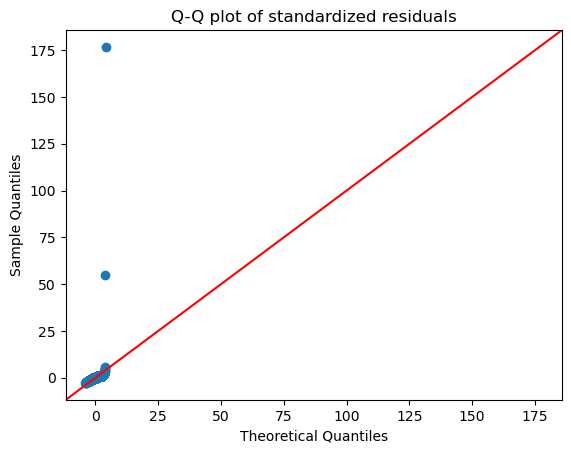

Shapiro-Wilk test p-value: 0.0


c:\Users\kaveh\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [28]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
# Convert boolean columns to numeric (1/0)
X_train_lr_numeric = X_train_lr.astype(int)

# Fit the logistic regression model using statsmodels
logreg_sm = sm.Logit(y_train, X_train_lr_numeric).fit()

# Calculate the fitted values (predicted probabilities)
fitted_values = logreg_sm.fittedvalues

# Calculate the residuals
residuals = y_train - fitted_values
residuals_std = (residuals - residuals.mean()) / residuals.std()

# Create a Q-Q plot of the standardized residuals
fig, ax = plt.subplots()
sm.qqplot(residuals_std, line='45', ax=ax)
ax.set_title("Q-Q plot of standardized residuals")
plt.show()

# Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals_std)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue)


In [30]:
import statsmodels.api as sm

# Add a constant to the feature matrix for the intercept
X_train_lr_numeric = sm.add_constant(X_train_lr_numeric)

# Fit the logistic regression model using statsmodels
logreg_sm = sm.Logit(y_train, X_train_lr_numeric).fit()

# Print the summary, which includes p-values for all coefficients
print(logreg_sm.summary())

# Extract the p-value for the 'weekend_admission' variable
p_value = logreg_sm.pvalues['weekend_admission']

# Compare the p-value to the significance level (usually 0.05) to determine whether the association is significant
if p_value < 0.05:
    print(f"The association between weekend admission and ICU mortality is statistically significant (p-value = {p_value:.4f})")
else:
    print(f"The association between weekend admission and ICU mortality is not statistically significant (p-value = {p_value:.4f})")


Optimization terminated successfully.
         Current function value: 0.207272
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:     hospital_mortality   No. Observations:                49225
Model:                          Logit   Df Residuals:                    49203
Method:                           MLE   Df Model:                           21
Date:                Sun, 23 Apr 2023   Pseudo R-squ.:                  0.3933
Time:                        00:32:11   Log-Likelihood:                -10203.
converged:                       True   LL-Null:                       -16818.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.6495        nan        nan        

# Model Diagnostics

**1. Check for multicollinearity using Variance Inflation Factor (VIF):**  

VIF values greater than 10 indicate high multicollinearity. If you find such features, consider removing them or using dimensionality reduction techniques (e.g., PCA) to reduce multicollinearity.

*Note. Because we have created dummy variables for the age group, we must drop one of the dummy variables to use as a reference category. When all the categories are included in the model, it leads to perfect multicollinearity (values = infinity).*

In [33]:
# Drop the reference category for the age group
X_train_lr_numeric_vif = X_train_lr_numeric.drop('age_group_age_less_than_1', axis=1)

# Calculate VIF for each feature in the dataset
vif = pd.DataFrame()
vif["feature"] = X_train_lr_numeric_vif.columns
vif["VIF"] = [variance_inflation_factor(X_train_lr_numeric_vif.values, i) for i in range(X_train_lr_numeric_vif.shape[1])]

# Display VIF for each feature
print(vif)



                          feature        VIF
0                           const  49.527233
1           after_hours_admission   1.128592
2        admission_type_EMERGENCY   2.231915
3           admission_type_URGENT   1.196210
4            any_vasopressor_used   1.157735
5         mean_hourly_urineoutput   1.009659
6                         avg_gcs   1.271028
7         long_title_has_aneurysm   1.024209
8        long_title_has_poisoning   1.023497
9       long_title_has_infarction   1.139750
10         long_title_has_failure   1.281522
11         long_title_has_cardiac   1.104886
12        long_title_has_neoplasm   1.046904
13                      rare_code   1.075034
14         mechanical_vent_needed   1.188552
15            age_group_age_13_18   1.053389
16            age_group_age_19_65   4.544869
17  age_group_age_greater_than_65   4.804520
18    partialpressureo2_range_low   1.040043
19            troponin_range_high   1.171195
20           platelets_range_high   1.009894
21        

**2. Check for model misspecification using residual plots:**  

A residual plot with no discernible patterns indicates a well-specified model. If you see any patterns or trends in the plot, it suggests that the model may be misspecified. Consider transforming the predictor variables, adding interaction terms, or using alternative modeling techniques to address the issue.

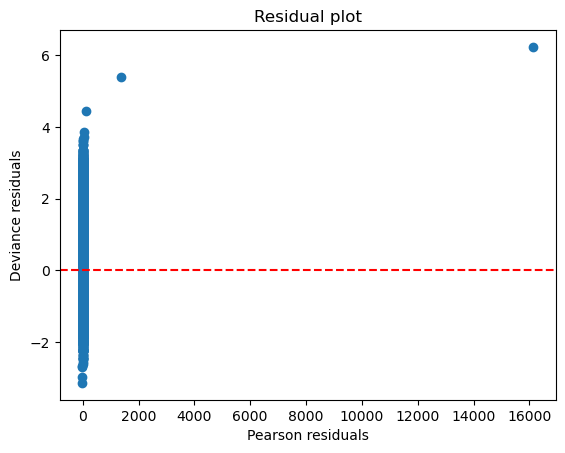

In [37]:
import matplotlib.pyplot as plt

# Calculate deviance residuals
deviance_residuals = logreg_sm.resid_dev

# Calculate Pearson residuals
pearson_residuals = logreg_sm.resid_pearson

# Create a residual plot
plt.scatter(pearson_residuals, deviance_residuals)
plt.xlabel("Pearson residuals")
plt.ylabel("Deviance residuals")
plt.title("Residual plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


Since most residuals are aligned on the 0 for the x-axis in a residual plot for a logistic regression model, it means that the observed values are very close to the predicted values for most of the observations. In other words, the model is doing a good job of fitting the data for the majority of the data points.

## Feature Importance:  

To analyse the importance of each feature in a logistic regression model, we can examine the coefficients and their corresponding p-values.  

Larger coefficients indicate that the corresponding feature has a greater impact on the outcome.  

Smaller p-values suggest that the relationship between the feature and the outcome is statistically significant.  

A negative coefficient means that an increase in the value of the feature is associated with a decrease in the probability of the outcome (ICU mortality risk), while a decrease in the value of the feature is associated with an increase in the probability of the outcome.

In [38]:
# Display the model summary to see the coefficients and their corresponding p-values.
print(logreg_sm.summary())

                           Logit Regression Results                           
Dep. Variable:     hospital_mortality   No. Observations:                49225
Model:                          Logit   Df Residuals:                    49203
Method:                           MLE   Df Model:                           21
Date:                Sun, 23 Apr 2023   Pseudo R-squ.:                  0.3933
Time:                        00:58:50   Log-Likelihood:                -10203.
converged:                       True   LL-Null:                       -16818.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.6495        nan        nan        nan         nan         nan
after_hours_admission             0.0442      0.038      1.158      0.247 

In [40]:
# Extract the coefficients and p-values from the model, and create a DataFrame to display the results.
coefficients = logreg_sm.params
p_values = logreg_sm.pvalues

# Create a DataFrame to display the results
feature_importance = pd.DataFrame({"Feature": X_train_lr.columns,
                                   "Coefficient": coefficients,
                                   "p-value": p_values})

# Sort the DataFrame by the absolute value of the coefficients in descending order
feature_importance = feature_importance.reindex(feature_importance.Coefficient.abs().sort_values(ascending=False).index)

print(feature_importance)


                                                     Feature  Coefficient  \
const                                                  const     1.649516   
admission_type_URGENT                  admission_type_URGENT     1.334561   
admission_type_EMERGENCY            admission_type_EMERGENCY     1.316296   
partialpressureo2_range_low      partialpressureo2_range_low     1.146784   
age_group_age_greater_than_65  age_group_age_greater_than_65     0.913830   
any_vasopressor_used                    any_vasopressor_used     0.512179   
avg_gcs                                              avg_gcs    -0.484480   
age_group_age_19_65                      age_group_age_19_65     0.454558   
long_title_has_neoplasm              long_title_has_neoplasm     0.333718   
mechanical_vent_needed                mechanical_vent_needed    -0.325013   
long_title_has_poisoning            long_title_has_poisoning    -0.309202   
troponin_range_high                      troponin_range_high     0.308994   